In [3]:
import os
import zipfile
import random
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
uploaded = files.upload()


Saving archive.zip to archive.zip


In [5]:
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

# Cek file hasil ekstrak
os.listdir("dataset")


['data']

In [6]:
for root, dirs, files in os.walk("dataset"):
    level = root.replace("dataset", "").count(os.sep)
    indent = "  " * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = "  " * (level + 1)
    for f in files[:5]:
        print(f"{subindent}{f}")

dataset/
  data/
    non-vehicles/
      extra1888.png
      image592.png
      image2658.png
      image2121.png
      image3165.png
    vehicles/
      4399.png
      right (139).png
      5435.png
      2769.png
      5045.png


In [7]:
base_dir = "split_dataset"
classes = ['vehicles', 'non-vehicles']
splits = ['train', 'val', 'test']
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

In [8]:
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)
def split_and_copy(src_dir, cls):
    files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(files)
    total = len(files)
    train_end = int(split_ratio['train'] * total)
    val_end = train_end + int(split_ratio['val'] * total)

    split_files = {
        'train': files[:train_end],
        'val': files[train_end:val_end],
        'test': files[val_end:]
    }

    for split, split_file_list in split_files.items():
        for f in split_file_list:
            shutil.copy2(os.path.join(src_dir, f), os.path.join(base_dir, split, cls, f))

for cls in classes:
    src = os.path.join("dataset/data", cls)
    split_and_copy(src, cls)

In [9]:
img_size = (150, 150)
batch_size = 32

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

In [10]:
train_data = train_gen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_data = val_gen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_data = test_gen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 12431 images belonging to 2 classes.
Found 2663 images belonging to 2 classes.
Found 2666 images belonging to 2 classes.


In [11]:
model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [13]:
history = model.fit(
    train_data,
    epochs=3,
    validation_data=val_data
)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


389/389 ━━━━━━━━━━━━━━━━━━━━ 774s 2s/step - accuracy: 0.8741 - loss: 0.2604 - val_accuracy: 0.9685 - val_loss: 0.0827
Epoch 2/3
389/389 ━━━━━━━━━━━━━━━━━━━━ 776s 2s/step - accuracy: 0.9787 - loss: 0.0592 - val_accuracy: 0.9805 - val_loss: 0.0485
Epoch 3/3
389/389 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.9839 - loss: 0.0468 - val_accuracy: 0.9895 - val_loss: 0.0306


In [14]:
loss, accuracy = model.evaluate(val_data)
print(f"Loss Validasi: {loss}")
print(f"Akurasi Validasi: {accuracy}")


84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 462ms/step - accuracy: 0.9901 - loss: 0.0307
Loss Validasi: 0.030649695545434952
Akurasi Validasi: 0.9894855618476868


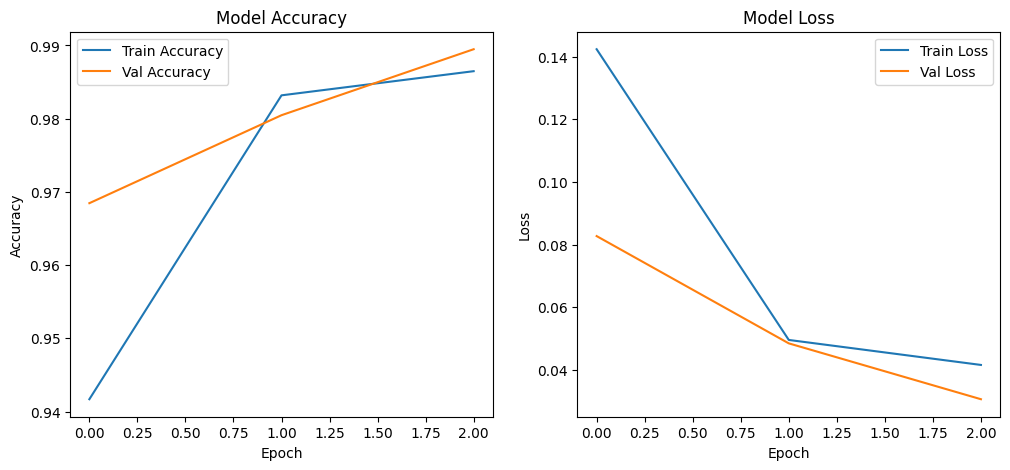

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [21]:
saved_model_path = "saved_model/vehicle_classifier"
model.export(saved_model_path)
print(f"✅ Model berhasil disimpan ke SavedModel di: {saved_model_path}")

Saved artifact at 'saved_model/vehicle_classifier'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133690497735696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133690497732240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133690497734736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133690497738384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133690497737616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133690497739344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133690497738768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133690497739728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133690497740112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133690497741648: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ 

In [22]:
tflite_converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = tflite_converter.convert()

In [23]:
tflite_path = "vehicle_classifier.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"✅ Model berhasil dikonversi ke TFLite di: {tflite_path}")

✅ Model berhasil dikonversi ke TFLite di: vehicle_classifier.tflite


In [25]:
tfjs_target_dir = "tfjs_model/"
# Hapus folder dulu kalau sudah ada
if os.path.exists(tfjs_target_dir):
    shutil.rmtree(tfjs_target_dir)

# Convert
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model {saved_model_path} {tfjs_target_dir}

print(f"✅ Model berhasil dikonversi ke TensorFlowJS di: {tfjs_target_dir}")

2025-04-28 04:03:40.434102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745813020.506749   15231 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745813020.534677   15231 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-28 04:03:49.776951: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1745813030.131800   15231 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00